# Load Libaries

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import datetime

In [ ]:
# Set Parameters
Height = 256
Width = 256
Channels = 3
kernel_size = (3,3)
shape = (Height, Width)

# Utility Functions

In [ ]:
def plotter(X_test, y_test, predictions):
    plt.figure(figsize=(10,10))

    plt.subplot(1,3,1)
    plt.imshow(X_test)
    plt.title("Ultrasound Image")

    plt.subplot(1,3,2)
    plt.imshow(y_test)
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(predictions)
    plt.title("Predicted Mask")

# Load BUSI Data

In [ ]:
# Import the Data

imgPath = '/content/drive/MyDrive/Datasets/Mini Dataset/Images/*.png'
maskPath = '/content/drive/MyDrive/Datasets/Mini Dataset/Masks/*.png'

img_name = glob.glob(imgPath)
msk_name = glob.glob(maskPath)

img_name.sort()
msk_name.sort()

trainingData = {'image':[], 'mask':[]}

def loadImages(imageData=None, imgList=None, mskList=None, shape=None):

    for img in imgList:
        image = cv2.imread(img, 1)
        image = cv2.resize(image, shape)
        imageData['image'].append(image)

    for msk in mskList:
        mask = cv2.imread(msk, 1)
        mask = cv2.resize(mask, shape)
        imageData['mask'].append(mask)

    return imageData


trainingData = loadImages(trainingData, img_name, msk_name, shape)


X_train = np.array(trainingData['image'])
y_train = np.array(trainingData['mask'])

X_train = X_train / 255.0
y_train = y_train / 255.0

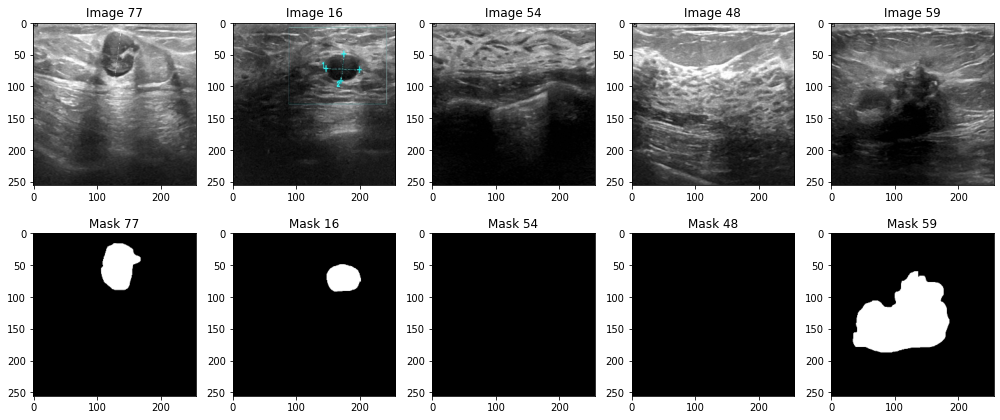

In [ ]:
import random

# Number of random images to display
num_random = 5

# Get random indices
random_indices = random.sample(range(len(X_train)), num_random)

plt.figure(figsize = (14,6))
for i, index in enumerate(random_indices):
    plt.subplot(2, num_random, i+1)
    plt.imshow(np.squeeze(X_train[index]), cmap = "gray")
    plt.title(f'Image {index+1}')
    plt.subplot(2, num_random, num_random+i+1)
    plt.imshow(np.squeeze(y_train[index]), cmap = "gray")
    plt.title(f'Mask {index+1}')
plt.tight_layout()
plt.show()

# Models

## U-Net

In [ ]:
# Build the UNet Architecture

inputLayer = Input((Height, Width, Channels))

# Encoder Path / Contraction Path

conv1 = Conv2D(64, kernel_size, padding='same', activation='relu')(inputLayer)
conv1 = Conv2D(64, kernel_size, padding='same', activation='relu')(conv1)
pool1 = MaxPool2D((2,2), strides=2, padding='same')(conv1)

conv2 = Conv2D(128, kernel_size, padding='same', activation='relu')(pool1)
conv2 = Conv2D(128, kernel_size, padding='same', activation='relu')(conv2)
pool2 = MaxPool2D((2,2), strides=2, padding='same')(conv2)

conv3 = Conv2D(256, kernel_size, padding='same', activation='relu')(pool2)
conv3 = Conv2D(256, kernel_size, padding='same', activation='relu')(conv3)
pool3 = MaxPool2D((2,2), strides=2, padding='same')(conv3)

conv4 = Conv2D(512, kernel_size, padding='same', activation='relu')(pool3)
conv4 = Conv2D(512, kernel_size, padding='same', activation='relu')(conv4)
pool4 = MaxPool2D((2,2), strides=2, padding='same')(conv4)

# Bottlekneck Layer

base = Conv2D(1024, kernel_size, padding='same', activation='relu')(pool4)

# Decoder Path / Expansion Path

trans1 = Conv2DTranspose(512, (2,2), strides=2, activation='relu')(base)
skip4 = Concatenate()([trans1, conv4])
conv5 = Conv2D(512, kernel_size, padding='same', activation='relu')(skip4)
conv5 = Conv2D(512, kernel_size, padding='same', activation='relu')(conv5)

trans2 = Conv2DTranspose(256, (2,2), strides=2, activation='relu')(conv5)
skip3 = Concatenate()([trans2, conv3])
conv6 = Conv2D(256, kernel_size, padding='same', activation='relu')(skip3)
conv6 = Conv2D(256, kernel_size, padding='same', activation='relu')(conv6)

trans3 = Conv2DTranspose(128, (2,2), strides=2, activation='relu')(conv6)
skip2 = Concatenate()([trans3, conv2])
conv7 = Conv2D(128, kernel_size, padding='same', activation='relu')(skip2)
conv7 = Conv2D(128, kernel_size, padding='same', activation='relu')(conv7)

trans4 = Conv2DTranspose(64, (2,2), strides=2, activation='relu')(conv7)
skip1 = Concatenate()([trans4, conv1])
conv8 = Conv2D(64, kernel_size, padding='same', activation='relu')(skip1)
conv8 = Conv2D(64, kernel_size, padding='same', activation='relu')(conv8)


# Output Layer
outputLayer = Conv2D(3, (1,1), padding='same', activation='sigmoid')(conv8)


#Build the model
UNet = Model(inputs=inputLayer, outputs=outputLayer, name='UNet')

In [ ]:
UNet.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
UNet.summary()

In [ ]:
pip install keras-flops

In [ ]:
# Calculae FLOPS
from keras_flops import get_flops
flops = get_flops(UNet, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 91.6 G


In [ ]:
print(np.shape(X_train))
print(np.shape(y_train))

(90, 256, 256, 3)
(90, 256, 256, 3)


In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

UNet.fit(X_train, y_train, epochs=10, validation_split=0.1)

print('Training Time: %s'%(now() - t))

Epoch 1/10
3/3 [==============================] - 44s 9s/step - loss: 0.6735 - accuracy: 1.6954e-06 - val_loss: 0.5439 - val_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 4s 1s/step - loss: 0.3586 - accuracy: 0.0000e+00 - val_loss: 0.2674 - val_accuracy: 0.0000e+00
Epoch 3/10
3/3 [==============================] - 4s 1s/step - loss: 0.2505 - accuracy: 0.0097 - val_loss: 0.2585 - val_accuracy: 0.9199
Epoch 4/10
3/3 [==============================] - 4s 1s/step - loss: 0.2327 - accuracy: 0.9575 - val_loss: 0.2456 - val_accuracy: 0.9976
Epoch 5/10
3/3 [==============================] - 4s 1s/step - loss: 0.2256 - accuracy: 0.9221 - val_loss: 0.2512 - val_accuracy: 9.4944e-05
Epoch 6/10
3/3 [==============================] - 4s 1s/step - loss: 0.2218 - accuracy: 4.9167e-05 - val_loss: 0.2262 - val_accuracy: 0.0000e+00
Epoch 7/10
3/3 [==============================] - 4s 1s/step - loss: 0.2178 - accuracy: 0.0000e+00 - val_loss: 0.2611 - val_accuracy: 0.0000e+00
Epoc

In [ ]:
# Make predictions

t = now()
preds = UNet.predict(X_train)
print('Testing time: %s' % (now() - t))

3/3 [==============================] - 1s 503ms/step
Testing time: 0:00:02.642553


In [ ]:
UNet.save("UNet.h5")

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("UNet.h5")

In [ ]:
loaded_model.summary()

## U-Net ++

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate

In [ ]:
smooth = 1.
dropout_rate = 0.5
act = "relu"

In [ ]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='relu',
               name='conv'+stage+'_1', kernel_initializer = 'he_normal',
               padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = tf.keras.layers.Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='relu',
               name='conv'+stage+'_2', kernel_initializer = 'he_normal',
               padding='same', kernel_regularizer=l2(1e-4))(x)
    x = tf.keras.layers.Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

In [ ]:
def UNetPlusPlus(img_rows, img_cols, color_type=1, num_class=1, deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Handle Dimension Ordering for different backends


    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=3)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=3)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=3)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=3)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=3)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=3)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=3)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid',
                              name='output_1', kernel_initializer = 'he_normal',
                              padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid',
                              name='output_2', kernel_initializer = 'he_normal',
                              padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid',
                              name='output_3', kernel_initializer = 'he_normal',
                              padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid',
                              name='output_4', kernel_initializer = 'he_normal',
                              padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(inputs=img_input, outputs=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(inputs=img_input, outputs=nestnet_output_4)

    return model

In [ ]:
UnetPlusPlus = UNetPlusPlus(256,256,1)

In [ ]:
UnetPlusPlus.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
UnetPlusPlus.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv11_1 (Conv2D)              (None, 256, 256, 32  320         ['main_input[0][0]']             
                                )                                                                 
                                                                                                  
 dp11_1 (Dropout)               (None, 256, 256, 32  0           ['conv11_1[0][0]']               
                                )                                                           

In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(UnetPlusPlus, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 59.6 G


In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

UnetPlusPlus.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size =16)

print('Training Time: %s'%(now() - t))

Epoch 1/10
6/6 [==============================] - 19s 2s/step - loss: 2.5436 - accuracy: 0.7832 - val_loss: 1.0465 - val_accuracy: 0.9413
Epoch 2/10
6/6 [==============================] - 5s 730ms/step - loss: 1.0480 - accuracy: 0.9289 - val_loss: 1.1241 - val_accuracy: 0.9413
Epoch 3/10
6/6 [==============================] - 5s 730ms/step - loss: 0.9832 - accuracy: 0.9349 - val_loss: 1.0947 - val_accuracy: 0.9413
Epoch 4/10
6/6 [==============================] - 5s 731ms/step - loss: 0.9478 - accuracy: 0.9373 - val_loss: 1.0189 - val_accuracy: 0.9413
Epoch 5/10
6/6 [==============================] - 5s 732ms/step - loss: 0.9126 - accuracy: 0.9385 - val_loss: 0.9372 - val_accuracy: 0.9413
Epoch 6/10
6/6 [==============================] - 5s 735ms/step - loss: 0.8818 - accuracy: 0.9390 - val_loss: 0.9255 - val_accuracy: 0.9413
Epoch 7/10
6/6 [==============================] - 5s 737ms/step - loss: 0.8544 - accuracy: 0.9391 - val_loss: 0.9471 - val_accuracy: 0.9413
Epoch 8/10
6/6 [======

In [ ]:
# Make predictions

t = now()
preds = UnetPlusPlus.predict(X_train)
print('Testing time: %s' % (now() - t))

3/3 [==============================] - 1s 495ms/step
Testing time: 0:00:01.452030


## Attention U-Net

In [ ]:
!pip install keras_unet_collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 KB 9.5 MB/s eta 0:00:00


In [ ]:
num_labels = 3  #Binary
input_shape = (Height, Width,Channels)
batch_size = 8

In [ ]:
from keras_unet_collection import models, losses

In [ ]:
model_att_unet = models.att_unet_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024],
                           n_labels=num_labels,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU',
                           atten_activation='ReLU', attention='add',
                           output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False,
                           backbone='VGG16', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='attunet')

In [ ]:
model_att_unet.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
model_att_unet.summary()

Model: "attunet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_backbone (Functional)    [(None, 256, 256, 6  14714688    ['input_7[0][0]']                
                                4),                                                               
                                 (None, 128, 128, 1                                               
                                28),                                                              
                                 (None, 64, 64, 256                                   

In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model_att_unet, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 1.09e+02 G


In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

model_att_unet.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size =16)

print('Training Time: %s'%(now() - t))

Epoch 1/10
6/6 [==============================] - 47s 2s/step - loss: 0.6202 - accuracy: 0.5661 - val_loss: 0.3052 - val_accuracy: 0.2759
Epoch 2/10
6/6 [==============================] - 4s 657ms/step - loss: 0.4476 - accuracy: 0.5942 - val_loss: 11.6080 - val_accuracy: 0.5012
Epoch 3/10
6/6 [==============================] - 4s 663ms/step - loss: 0.3383 - accuracy: 0.2591 - val_loss: 133.3233 - val_accuracy: 0.5001
Epoch 4/10
6/6 [==============================] - 4s 661ms/step - loss: 0.2779 - accuracy: 0.1779 - val_loss: 689.5743 - val_accuracy: 0.8014
Epoch 5/10
6/6 [==============================] - 4s 662ms/step - loss: 0.2433 - accuracy: 0.1640 - val_loss: 483.1647 - val_accuracy: 0.5113
Epoch 6/10
6/6 [==============================] - 4s 661ms/step - loss: 0.2205 - accuracy: 0.2400 - val_loss: 417.6905 - val_accuracy: 0.6779
Epoch 7/10
6/6 [==============================] - 4s 663ms/step - loss: 0.1966 - accuracy: 0.2540 - val_loss: 305.9339 - val_accuracy: 0.9980
Epoch 8/10


In [ ]:
# Make predictions

t = now()
preds = model_att_unet.predict(X_train)
print('Testing time: %s' % (now() - t))

3/3 [==============================] - 1s 601ms/step
Testing time: 0:00:01.841622


## EfficientU-Net

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

In [ ]:
def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
def encoder(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

In [ ]:
def encoder(inputs):
    skip_connections = []

    model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block2a_expand_conv", "block3a_expand_conv", "block4a_expand_conv", "block5a_expand_conv"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5b_expand_conv").output
    return output, skip_connections

In [ ]:
def encoder(inputs):
    skip_connections = []

    model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["input_6", "block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5a_expand_activation").output
    return output, skip_connections

In [ ]:
def decoder(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

In [ ]:
def output_block(inputs):
    x = Conv2D(3, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

In [ ]:
def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

In [ ]:
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

In [ ]:
def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder(inputs)
    x = ASPP(x, 64)
    x = decoder(x, skip_1)
    outputs = output_block(x)

    model = Model(inputs, outputs)
    return model

In [ ]:
model = build_model((256, 256, 3))

In [ ]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 256, 256, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_5 (Normalization  (None, 256, 256, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 27.7 G


In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size =16)

print('Training Time: %s'%(now() - t))

Epoch 1/10
6/6 [==============================] - 28s 2s/step - loss: 0.6549 - accuracy: 0.2301 - val_loss: 0.6734 - val_accuracy: 2.2040e-05
Epoch 2/10
6/6 [==============================] - 6s 1s/step - loss: 0.4759 - accuracy: 0.1066 - val_loss: 0.4848 - val_accuracy: 6.6121e-05
Epoch 3/10
6/6 [==============================] - 6s 1s/step - loss: 0.4030 - accuracy: 0.0256 - val_loss: 0.3810 - val_accuracy: 0.0144
Epoch 4/10
6/6 [==============================] - 6s 986ms/step - loss: 0.3352 - accuracy: 0.0141 - val_loss: 0.6124 - val_accuracy: 0.9720
Epoch 5/10
6/6 [==============================] - 6s 980ms/step - loss: 0.3012 - accuracy: 0.0238 - val_loss: 0.6013 - val_accuracy: 0.0384
Epoch 6/10
6/6 [==============================] - 6s 991ms/step - loss: 0.2824 - accuracy: 0.0138 - val_loss: 0.3695 - val_accuracy: 0.0095
Epoch 7/10
6/6 [==============================] - 6s 983ms/step - loss: 0.2532 - accuracy: 0.0318 - val_loss: 0.5615 - val_accuracy: 0.0105
Epoch 8/10
6/6 [====

In [ ]:
# Make predictions

t = now()
preds = model.predict(X_train)
print('Testing time: %s' % (now() - t))

3/3 [==============================] - 1s 494ms/step
Testing time: 0:00:01.532025


## Efficient U-Net without AC block

In [ ]:
!pip install keras_unet_collection

In [ ]:
from keras_unet_collection import models
#help(models.unet_2d)


model = models.unet_2d((256, 256, 3), filter_num=[32, 64, 128, 256],
                           n_labels=3,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU',
                           output_activation='Sigmoid',
                           batch_norm=True, pool='max', unpool=False,
                           backbone='EfficientNetB7', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=False,
                           name='unet')

In [ ]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 EfficientNetB7_backbone (Funct  [(None, 128, 128, 1  1045443    ['input_3[0][0]']                
 ional)                         92),                                                              
                                 (None, 64, 64, 288                                               
                                ),                                                                
                                 (None, 32, 32, 480                                      

In [ ]:
! pip install keras_flops

In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 23.2 G


In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size =16)

print('Training Time: %s'%(now() - t))

Epoch 1/10
6/6 [==============================] - 27s 1s/step - loss: 0.8277 - accuracy: 0.1349 - val_loss: 0.7246 - val_accuracy: 0.9850
Epoch 2/10
6/6 [==============================] - 2s 374ms/step - loss: 0.6674 - accuracy: 0.2605 - val_loss: 0.8411 - val_accuracy: 0.9904
Epoch 3/10
6/6 [==============================] - 2s 390ms/step - loss: 0.5909 - accuracy: 0.3053 - val_loss: 0.8401 - val_accuracy: 0.9795
Epoch 4/10
6/6 [==============================] - 2s 392ms/step - loss: 0.5431 - accuracy: 0.3103 - val_loss: 0.8514 - val_accuracy: 0.6950
Epoch 5/10
6/6 [==============================] - 2s 383ms/step - loss: 0.5075 - accuracy: 0.3868 - val_loss: 0.7623 - val_accuracy: 0.3586
Epoch 6/10
6/6 [==============================] - 2s 381ms/step - loss: 0.4707 - accuracy: 0.5602 - val_loss: 0.7357 - val_accuracy: 0.2857
Epoch 7/10
6/6 [==============================] - 2s 382ms/step - loss: 0.4420 - accuracy: 0.6771 - val_loss: 0.6192 - val_accuracy: 0.3858
Epoch 8/10
6/6 [======

In [ ]:
# Make predictions

t = now()
preds = model.predict(X_train)
print('Testing time: %s' % (now() - t))

3/3 [==============================] - 1s 415ms/step
Testing time: 0:00:01.313622


## SAU-Net

In [ ]:
input_size = (Height, Width,Channels)
import tensorflow as tf
import numpy as np

from keras import Model
from keras.models import Sequential
from keras.layers.core import Reshape, Flatten
from keras.layers import Input, Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, Dropout, concatenate
from keras.layers import add, multiply, subtract
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, \
    UpSampling2D, Lambda
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, concatenate, \
    BatchNormalization, Concatenate

In [ ]:
# Expand a tensor by repeating the elements in a dimension
def expend_as(tensor, rep):
    my_repeat = tf.keras.layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)
    return my_repeat

In [ ]:
# Salient attention block
def SalientAttentionBlock(f_maps, sal_ins, pool_maps, num_fmaps):
    # Inputs: feature maps from UNet, saliency images, pooled layers from UNet, number of output feature maps
    conv1_salins = Conv2D(128, (1, 1), activation='relu')(sal_ins)
    conv1_fmaps = Conv2D(128, (1, 1), strides=(2, 2), activation='relu')(f_maps)
    attn_add = tf.keras.layers.add([conv1_fmaps,conv1_salins])
    conv_1d = Conv2D(128, (3, 3), activation='relu', padding='same')(attn_add)
    conv_1d = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_1d)
    conv_1d = Conv2D(1, (1, 1), activation='relu')(conv_1d)
    conv_1d = expend_as(conv_1d,32)
    conv_nd = Conv2D(num_fmaps, (1, 1), activation='relu')(conv_1d)
    attn_act = tf.keras.layers.Activation('sigmoid')(conv_nd)
    attn = tf.keras.layers.multiply([attn_act, pool_maps])
    return attn

# Convolutional block for UNet
def UNetBlock(in_fmaps, num_fmaps):
    # Inputs: feature maps for UNet, number of output feature maps
    conv1 = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(in_fmaps)
    conv_out = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(conv1)
    return conv_out

In [ ]:
# Build the model
def Network():

    input = Input(shape=input_size)

    conv1 = UNetBlock(input, 32)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    input2 = Input(shape=input_size)

    dwns1 = tf.keras.layers.MaxPooling2D(2,2)(input2)
    attn1 = SalientAttentionBlock(conv1, dwns1, pool1, 32)

    conv2 = UNetBlock(attn1, 32)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    dwns2 = tf.keras.layers.MaxPooling2D(4,4)(input2)
    attn2 = SalientAttentionBlock(conv2, dwns2, pool2, 32)

    conv3 = UNetBlock(attn2, 64)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    dwns3 = tf.keras.layers.MaxPooling2D(8,8)(input2)
    attn3 = SalientAttentionBlock(conv3, dwns3, pool3, 64)

    conv4 = UNetBlock(attn3, 64)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    dwns4 = tf.keras.layers.MaxPooling2D(16,16)(input2)
    attn4 = SalientAttentionBlock(conv4, dwns4, pool4, 64)

    conv5 = UNetBlock(attn4, 128)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), attn3], axis=3)
    conv6 = UNetBlock(up6, 64)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), attn2], axis=3)
    conv7 = UNetBlock(up7, 64)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), attn1], axis=3)
    conv8 = UNetBlock(up8, 32)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = UNetBlock(up9, 32)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs = [input, input2], outputs = conv10)

    return model

In [ ]:
model = Network()

In [ ]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
# Get the number of parameters
num_params = model.count_params()

# Print the number of parameters
print("Number of parameters: ", num_params)

Number of parameters:  1914117


In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 21.5 G


In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size =16)

print('Training Time: %s'%(now() - t))

In [ ]:
# Make predictions

t = now()
preds = model.predict(X_train)
print('Testing time: %s' % (now() - t))

3/3 [==============================] - 1s 476ms/step
Testing time: 0:00:01.474184


## SKU-Net

### Functions

In [ ]:
import numpy as np

from keras import Model
from keras.models import Sequential
from keras.layers.core import Reshape, Flatten
from keras.layers import Input, Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, Dropout, concatenate
from keras.layers import add, multiply, subtract
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, \
    UpSampling2D, Lambda
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, concatenate, \
    BatchNormalization, Concatenate


## FUNCTIONS

def dice_coef_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    intersection = np.sum(y_true_f * y_pred_f)

    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))


def voe_coef_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    intersection = np.sum(y_true_f * y_pred_f)

    return (1 - intersection /
            (np.sum(y_true_f) + np.sum(y_pred_f) - intersection))


## LAYERS

def expend_as(x, n):
    y = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
               arguments={'repnum': n})(x)

    return y


def conv_bn_act(x, filters, drop_out=0.0):
    x = Conv2D(filters, (3, 3), activation=None, padding='same')(x)

    if drop_out > 0:
        x = Dropout(drop_out)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


def bn_act_conv_dense(x, filters, drop_out=0.0):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same')(x)

    if drop_out > 0:
        x = Dropout(drop_out)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)

    if drop_out > 0:
        x = Dropout(drop_out)(x)

    return x


def dense_block(x, elements=3, filters=8, drop_out=0.0):
    blocks = [x]

    for i in range(elements):
        temp = bn_act_conv_dense(x, filters, drop_out)
        blocks.append(temp)
        x = Concatenate(axis=-1)(blocks)

    return x


def selective_layer(x, filters, compression=0.5, drop_out=0.0):
    x1 = Conv2D(filters, (3, 3), dilation_rate=2, padding='same')(x)

    if drop_out > 0:
        x1 = Dropout(drop_out)(x1)

    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(filters, (3, 3), padding='same')(x)

    if drop_out > 0:
        x2 = Dropout(drop_out)(x2)

    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    x3 = add([x1, x2])

    x3 = GlobalAveragePooling2D()(x3)

    x3 = Dense(int(filters * compression))(x3)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)

    x3 = Dense(filters)(x3)

    x3p = Activation('sigmoid')(x3)

    x3m = Lambda(lambda x: 1 - x)(x3p)

    x4 = multiply([x1, x3p])
    x5 = multiply([x2, x3m])

    return add([x4, x5])


def selective_transition_layer(x, filters, drop_out=0.0):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = selective_layer(x, filters, drop_out=drop_out)

    return x


def transition_layer(x, compression, drop_out=0.0):
    n = K.int_shape(x)[-1]

    n = int(n * compression)

    x = BatchNormalization()(x)
    x = Conv2D(n, (1, 1), padding='same')(x)

    if drop_out > 0:
        x = Dropout(drop_out)(x)

    return x


def attention_layer(d, e, n):
    d1 = Conv2D(n, (1, 1), activation=None, padding='same')(d)

    e1 = Conv2D(n, (1, 1), activation=None, padding='same')(e)

    concat_de = add([d1, e1])

    relu_de = Activation('relu')(concat_de)
    conv_de = Conv2D(1, (1, 1), padding='same')(relu_de)
    sigmoid_de = Activation('sigmoid')(conv_de)

    shape_e = K.int_shape(e)
    upsample_psi = expend_as(sigmoid_de, shape_e[3])

    return multiply([upsample_psi, e])


## SEGMENTATION NETWORKS

def unet(filters=16, dropout=0, size=(224, 224, 1), attention_gates=False):
    inp = Input(size)

    c1 = conv_bn_act(inp, filters)
    c1 = conv_bn_act(c1, filters)
    p1 = MaxPooling2D((2, 2))(c1)
    filters = 2 * filters

    c2 = conv_bn_act(p1, filters)
    c2 = conv_bn_act(c2, filters)
    p2 = MaxPooling2D((2, 2))(c2)
    filters = 2 * filters

    c3 = conv_bn_act(p2, filters)
    c3 = conv_bn_act(c3, filters)
    p3 = MaxPooling2D((2, 2))(c3)
    filters = 2 * filters

    c4 = conv_bn_act(p3, filters)
    c4 = conv_bn_act(c4, filters)
    p4 = MaxPooling2D((2, 2))(c4)
    filters = 2 * filters

    cm = conv_bn_act(p4, filters)
    cm = conv_bn_act(cm, filters)

    filters = filters // 2

    u4 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(cm)

    if attention_gates:

        u4 = concatenate([u4, attention_layer(u4, c4, 1)], axis=3)

    else:

        u4 = concatenate([u4, c4], axis=3)

    c5 = conv_bn_act(u4, filters)
    c5 = conv_bn_act(c5, filters)

    filters = filters // 2

    u3 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(c5)

    if attention_gates:

        u3 = concatenate([u3, attention_layer(u3, c3, 1)], axis=3)

    else:

        u3 = concatenate([u3, c3], axis=3)

    c6 = conv_bn_act(u3, filters)
    c6 = conv_bn_act(c6, filters)

    filters = filters // 2

    u2 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(c6)

    if attention_gates:

        u2 = concatenate([u2, attention_layer(u2, c2, 1)], axis=3)

    else:

        u2 = concatenate([u2, c2], axis=3)

    c7 = conv_bn_act(u2, filters)
    c7 = conv_bn_act(c7, filters)

    filters = filters // 2

    u1 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(c7)

    if attention_gates:

        u1 = concatenate([u1, attention_layer(u1, c1, 1)], axis=3)

    else:

        u1 = concatenate([u1, c1], axis=3)

    c8 = conv_bn_act(u1, filters)
    c8 = conv_bn_act(c8, filters)

    c9 = Conv2D(1, (1, 1), padding="same", activation='sigmoid')(c8)

    return Model(inputs=[inp], outputs=[c9])


def selective_unet(filters=16, drop_out=0, compression=0.5, size=(224, 224, 1),
                   half_net=False, attention_gates=False):
    inp = Input(size)

    c1 = selective_layer(inp, filters, compression=compression,
                         drop_out=drop_out)
    c1 = selective_layer(c1, filters, compression=compression,
                         drop_out=drop_out)
    p1 = MaxPooling2D((2, 2))(c1)
    filters = 2 * filters

    c2 = selective_layer(p1, filters, compression=compression,
                         drop_out=drop_out)
    c2 = selective_layer(c2, filters, compression=compression,
                         drop_out=drop_out)
    p2 = MaxPooling2D((2, 2))(c2)
    filters = 2 * filters

    c3 = selective_layer(p2, filters, compression=compression,
                         drop_out=drop_out)
    c3 = selective_layer(c3, filters, compression=compression,
                         drop_out=drop_out)
    p3 = MaxPooling2D((2, 2))(c3)
    filters = 2 * filters

    c4 = selective_layer(p3, filters, compression=compression,
                         drop_out=drop_out)
    c4 = selective_layer(c4, filters, compression=compression,
                         drop_out=drop_out)
    p4 = MaxPooling2D((2, 2))(c4)
    filters = 2 * filters

    cm = selective_layer(p4, filters, compression=compression,
                         drop_out=drop_out)
    cm = selective_layer(cm, filters, compression=compression,
                         drop_out=drop_out)

    filters = filters // 2

    u4 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(cm)

    if attention_gates:

        u4 = concatenate([u4, attention_layer(u4, c4, 1)], axis=3)

    else:

        u4 = concatenate([u4, c4], axis=3)

    if half_net:

        c5 = conv_bn_act(u4, filters, drop_out=drop_out)
        c5 = conv_bn_act(c5, filters, drop_out=drop_out)

    else:

        c5 = selective_layer(u4, filters, compression=compression,
                             drop_out=drop_out)
        c5 = selective_layer(c5, filters, compression=compression,
                             drop_out=drop_out)

    filters = filters // 2

    u3 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(c5)

    if attention_gates:

        u3 = concatenate([u3, attention_layer(u3, c3, 1)], axis=3)

    else:

        u3 = concatenate([u3, c3], axis=3)

    if half_net:

        c6 = conv_bn_act(u3, filters, drop_out=drop_out)
        c6 = conv_bn_act(c6, filters, drop_out=drop_out)

    else:

        c6 = selective_layer(u3, filters, compression=compression,
                             drop_out=drop_out)
        c6 = selective_layer(c6, filters, compression=compression,
                             drop_out=drop_out)

    filters = filters // 2

    u2 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(c6)

    if attention_gates:

        u2 = concatenate([u2, attention_layer(u2, c2, 1)], axis=3)

    else:

        u2 = concatenate([u2, c2], axis=3)

    if half_net:

        c7 = conv_bn_act(u2, filters, drop_out=drop_out)
        c7 = conv_bn_act(c7, filters, drop_out=drop_out)

    else:

        c7 = selective_layer(u2, filters, compression=compression,
                             drop_out=drop_out)
        c7 = selective_layer(c7, filters, compression=compression,
                             drop_out=drop_out)

    filters = filters // 2

    u1 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(c7)

    if attention_gates:

        u1 = concatenate([u1, attention_layer(u1, c1, 1)], axis=3)

    else:

        u1 = concatenate([u1, c1], axis=3)

    if half_net:

        c8 = conv_bn_act(u1, filters, drop_out=drop_out)
        c8 = conv_bn_act(c8, filters, drop_out=drop_out)

    else:

        c8 = selective_layer(u1, filters, compression=compression,
                             drop_out=drop_out)
        c8 = selective_layer(c8, filters, compression=compression,
                             drop_out=drop_out)

    c9 = Conv2D(1, (1, 1), padding="same", activation='sigmoid')(c8)

    return Model(inputs=[inp], outputs=[c9])


def dense_unet(filters=8, blocks=3, layers=3, compression=0.5, drop_out=0,
               size=(224, 224, 1), half_net=False, attention_gates=False):
    inp = Input(size)

    x = Conv2D(filters, (3, 3), activation=None, padding='same')(inp)

    if drop_out > 0:
        x = Dropout(drop_out)(x)

    names = {}

    for i in range(layers):
        x = dense_block(x, blocks, filters, drop_out)
        x = transition_layer(x, compression, drop_out)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        name = 'x' + str(i + 1)
        names[name] = x

        x = MaxPooling2D((2, 2))(x)

        filters = 2 * filters

    x = dense_block(x, blocks, filters, drop_out)
    x = transition_layer(x, compression, drop_out)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for i in range(layers):

        filters = filters // 2

        name = 'x' + str(layers - i)

        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)

        if attention_gates:

            x = concatenate([x, attention_layer(x, names[name], 1)], axis=3)

        else:

            x = concatenate([x, names[name]], axis=3)

        if half_net:

            x = conv_bn_act(x, filters, drop_out)
            x = conv_bn_act(x, filters, drop_out)

        else:

            x = dense_block(x, blocks, filters, drop_out)
            x = transition_layer(x, compression, drop_out)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    x = Conv2D(1, (1, 1), padding="same", activation='sigmoid')(x)

    return Model(inputs=[inp], outputs=[x])

### Main

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from os import listdir

In [ ]:
images_udiat, rois_udiat = [], []

dsize = (224, 224)

path = '/content/drive/MyDrive/Datasets/Mini Dataset/'
img_file = listdir(path+'Images')

for i, file in enumerate(img_file):

    img = cv2.imread(path+'Images/'+file, 0)
    roi = cv2.imread(path+'Masks/'+file, 0)/255

    img = cv2.resize(img, dsize, interpolation=cv2.INTER_CUBIC)
    roi = cv2.resize(roi, dsize, interpolation=cv2.INTER_NEAREST)

    images_udiat.append(img)
    rois_udiat.append(roi)

images_udiat = np.array(images_udiat, dtype=np.float32)
images_udiat = np.expand_dims(images_udiat, 3)

rois_udiat = np.array(rois_udiat, dtype=np.int16)
rois_udiat = np.expand_dims(rois_udiat, 3)

In [ ]:
model = selective_unet()
#model.load_weights('/content/drive/MyDrive/skunet_weights.h5')

In [ ]:
# Get the number of parameters
num_params = model.count_params()

# Print the number of parameters
print("Number of parameters: ", num_params)

Number of parameters:  3942337


In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 9.09 G


In [ ]:
now = datetime.datetime.now
t = now()
rois_predicted = model.predict(images_udiat).squeeze().round()
print('Testing time: %s' % (now() - t))

3/3 [==============================] - 24s 8s/step
Testing time: 0:00:41.009954


In [ ]:
dices = np.zeros(rois_predicted.shape[0])

for i in range(rois_predicted .shape[0]):

    dices[i] = dice_coef_np(rois_predicted[i], rois_udiat[i])

In [ ]:
# Results are slightly different compared to our paper. Originally, we additionally preprocessed the images in Matlab.
print('Dice scores | mean:', np.mean(dices).round(3), 'median:', np.median(dices).round(3), 'mean Dice>0.5:', np.mean(dices[dices>0.5]).round

## AAU-Net

### Functions

In [ ]:
# coding=utf-8
from tensorflow.keras.layers import *
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.models import *


def expend_as(tensor, rep):
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)
    return my_repeat

# Channel attentation
def Channelblock(data, filte):
    conv1 = Conv2D(filte, (3, 3), padding="same",dilation_rate=(3,3))(data)
    batch1 = BatchNormalization()(conv1)
    LeakyReLU1 = ReLU()(batch1)

    conv2 = Conv2D(filte, (5, 5), padding="same")(data)
    batch2 = BatchNormalization()(conv2)
    LeakyReLU2 = ReLU()(batch2)

    data3 = concatenate([LeakyReLU1, LeakyReLU2])
    data3 = GlobalAveragePooling2D()(data3)
    data3 = Dense(units=filte)(data3)
    data3 = BatchNormalization()(data3)
    data3 = ReLU()(data3)
    data3 = Dense(units=filte)(data3)
    data3 = Activation('sigmoid')(data3)

    a = Reshape((1, 1, filte))(data3)

    a1 = 1-data3
    a1 = Reshape((1, 1, filte))(a1)

    y = multiply([LeakyReLU1, a])

    y1 = multiply([LeakyReLU2, a1])

    data_a_a1 = concatenate([y, y1])

    conv3 = Conv2D(filte, (1, 1), padding="same")(data_a_a1)
    batch3 = BatchNormalization()(conv3)
    LeakyReLU3 = ReLU()(batch3)
    return LeakyReLU3

# spatial attentation
def Spatialblock(data, channel_data, filte, size):
    conv1 = Conv2D(filte, (3, 3), padding="same")(data)
    batch1 = BatchNormalization()(conv1)
    LeakyReLU1 = ReLU()(batch1)


    conv2 = Conv2D(filte, (1, 1), padding="same")(LeakyReLU1)
    batch2 = BatchNormalization()(conv2)
    LeakyReLU2 = ReLU()(batch2)

    spatil_data = LeakyReLU2

    data3 = add([channel_data, spatil_data])
    data3 = ReLU()(data3)
    data3 = Conv2D(1, (1, 1), padding='same')(data3)
    data3 = Activation('sigmoid')(data3)

    a = expend_as(data3, filte)
    y = multiply([a, channel_data])

    a1 = 1-data3
    a1 = expend_as(a1, filte)
    y1 = multiply([a1, spatil_data])

    data_a_a1 = concatenate([y, y1])

    conv3 = Conv2D(filte, size, padding='same')(data_a_a1)
    batch3 = BatchNormalization()(conv3)

    return batch3

def HAAM(data, filte,size):

    channel_data = Channelblock(data=data, filte=filte)

    haam_data = Spatialblock(data, channel_data, filte, size)

    return haam_data

### Main ARch

In [ ]:
inputLayer = Input((Height, Width, Channels))

# Encoder Path / Contraction Path

conv1 = HAAM(inputLayer, 64, kernel_size)
conv1 = HAAM(conv1, 64, kernel_size)
pool1 = MaxPool2D((2,2), strides=2, padding='same')(conv1)

conv2 = HAAM(pool1, 128, kernel_size)
conv2 = HAAM(conv2, 128, kernel_size)
pool2 = MaxPool2D((2,2), strides=2, padding='same')(conv2)

conv3 = HAAM(pool2, 256, kernel_size)
conv3 = HAAM(conv3, 256, kernel_size)
pool3 = MaxPool2D((2,2), strides=2, padding='same')(conv3)

conv4 = HAAM(pool3, 512, kernel_size)
conv4 = HAAM(conv4, 512, kernel_size)
pool4 = MaxPool2D((2,2), strides=2, padding='same')(conv4)

# Bottlekneck Layer

base = HAAM(pool4, 1024, kernel_size)

# Decoder Path / Expansion Path

trans1 = Conv2DTranspose(512, (2,2), strides=2, activation='relu')(base)
skip4 = Concatenate()([trans1, conv4])
conv5 = HAAM(skip4, 512, kernel_size)
conv5 = HAAM(conv5, 512, kernel_size)

trans2 = Conv2DTranspose(256, (2,2), strides=2, activation='relu')(conv5)
skip3 = Concatenate()([trans2, conv3])
conv6 = HAAM(skip3, 256, kernel_size)
conv6 = HAAM(conv6, 256, kernel_size)

trans3 = Conv2DTranspose(128, (2,2), strides=2, activation='relu')(conv6)
skip2 = Concatenate()([trans3, conv2])
conv7 = HAAM(skip2, 128, kernel_size)
conv7 = HAAM(conv7, 128, kernel_size)

trans4 = Conv2DTranspose(64, (2,2), strides=2, activation='relu')(conv7)
skip1 = Concatenate()([trans4, conv1])
conv8 = HAAM(skip1, 64, kernel_size)
conv8 = HAAM(conv8, 64, kernel_size)

# Output Layer
outputLayer = Conv2D(3, (1,1), padding='same', activation='sigmoid')(conv8)

# Build the model
New_UNet = Model(inputs=inputLayer, outputs=outputLayer, name='New_UNet')


In [ ]:
New_UNet.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
New_UNet.summary()

Model: "New_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_311 (Conv2D)            (None, 256, 256, 64  1792        ['input_29[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_312 (Conv2D)            (None, 256, 256, 64  4864        ['input_29[0][0]']               
                                )                                                          

In [ ]:
pip install keras-flops

In [ ]:
# Calculae FLOPS
from keras_flops import get_flops
flops = get_flops(New_UNet, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


FLOPS: 6.18e+02 G


In [ ]:
print(np.shape(X_train))
print(np.shape(y_train))

(90, 256, 256, 3)
(90, 256, 256, 3)


In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

New_UNet.fit(X_train, y_train, epochs=10, validation_split=0.1)

print('Training Time: %s'%(now() - t))

Epoch 1/10


In [ ]:
# Make predictions

t = now()
preds = UNet.predict(X_train)
print('Testing time: %s' % (now() - t))

3/3 [==============================] - 1s 493ms/step
Testing time: 0:00:01.524798


In [ ]:
UNet.save("UNet.h5")

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("UNet.h5")

In [ ]:
loaded_model.summary()